# Naive implementation of OCSVM (Schölkopf) in Tensorflow
[Original paper by Schölkopf](https://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)

Here is our implementation with linear kernel

### $$ \frac{1}{2} \Vert{w}\Vert^{2} - \rho + C \sum_{i=1}^N \xi_i $$
subject to constraint:

### $$ w^{T} x_i \geq \rho - \xi_i$$

- $w$ and $\rho$ are the parameters who define the hyperplan separating data from the origin
- $\xi_i$ are slack variables that are zero if $x_i$ is in the sphere, and represent its distance to the sphere otherwise
- $C$ controls the hardness of the margin

In [1]:
import sys
import tensorflow as tf
import numpy as np

/Users/Sylvain/.pyenv/versions/3.6.4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DIMS = 2
INPUTS_NBR = 50
C = 3

# Variables to train
ro = tf.Variable(tf.random_normal([], mean=0.1), dtype=tf.float32, name="Radius")
w = tf.Variable(tf.random_normal([DIMS], mean=0.1), dtype=tf.float32, name="Center")

# Inputs and constants
X = tf.placeholder(tf.float32, shape=(None, DIMS), name="X")
C = tf.constant(3, dtype=tf.float32)

# Define the loss

In [3]:
constraint = tf.matmul(X, tf.expand_dims(w, -1)) - ro
loss = 0.5 * tf.square(tf.norm(w)) - ro - C * tf.reduce_sum(tf.minimum(constraint, 0.0))

# the loss is summed over all the batch
loss = tf.reduce_sum(loss)

# Define the optimizer and train

In [4]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(loss)

EPOCHS = 5000

inputs = np.random.normal(3*np.ones(DIMS), scale=1, size=(INPUTS_NBR, DIMS))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(EPOCHS):
        _, l, ro1, w1 = sess.run([train, loss, ro, w], feed_dict={X: inputs})
        
        towrite = "\r{0:4.1f} %, Loss: {1:7.4f}, ro: {2:7.4f}, w1:".format(e / EPOCHS * 100, l, ro1) + str(w1)
        sys.stdout.write(towrite)
        sys.stdout.flush()

100.0 %, Loss: -0.5000, ro:  1.0175, w1:[0.9287475  0.41378137]]

# Visualize the outputs

In [15]:
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

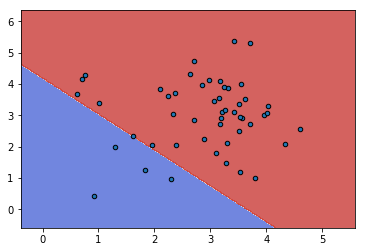

In [28]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.1, kernel="linear")
clf.fit(inputs)

fig = plt.gcf()
ax = fig.gca()
X0, X1 = inputs[:, 0], inputs[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
plt.show()

In [25]:
w1

array([0.9287475 , 0.41378137], dtype=float32)

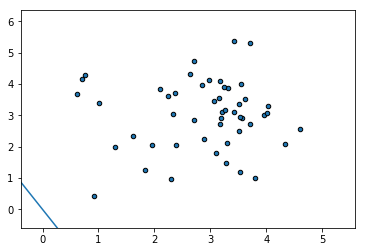

In [30]:
fig = plt.gcf()
ax = fig.gca()
X0, X1 = inputs[:, 0], inputs[:, 1]
xx, yy = make_meshgrid(X0, X1)

a = -w1[0] / w1[1]
xx2 = np.linspace(-5, 5)
yy2 = a * xx2

ax.scatter(X0, X1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.plot(xx2,yy2)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
plt.show()